# Wetland histograms

**Background**

**What does this notebook do?** This notebook generates histograms of raster properties for wetland and non-wetland regions in Queensland.

**Date**: Aug 2020.

**Author**: Matthew Alger

## Setup

Set up the notebook and load the data.

In [71]:
import functools
import os
import sys

import datacube
import geopandas as gpd
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
from odc.ui import with_ui_cbk
import rasterio.features
from shapely.geometry import shape
from shapely.validation import explain_validity
from tqdm.notebook import tqdm
import xarray

sys.path.append('../Scripts')
from dea_dask import create_local_dask_cluster
from dea_plotting import rgb

In [4]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:37275 Dashboard: /user/alger/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


In [5]:
dc = datacube.Datacube(app='wetland-histograms')

In [6]:
wetlands = gpd.read_file('Queensland_dominant_wetland_areas_22042020.shp')

In [7]:
tiles = gpd.read_file('QLDTestTiles.shp')

In [8]:
validity = wetlands.geometry.apply(explain_validity)

In [9]:
invalid = validity != 'Valid Geometry'

In [10]:
# Fix invalid geometries.
fixed_wetlands = wetlands[invalid].geometry.buffer(0)
wetlands.loc[invalid, 'geometry'] = fixed_wetlands

## Load rasters

In [11]:
sampled_wetlands = wetlands.geometry.intersection(tiles.unary_union)

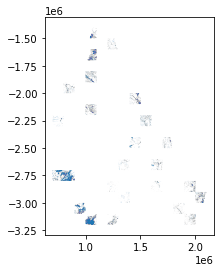

In [12]:
sampled_wetlands.plot()

In [13]:
wetlands = wetlands[~sampled_wetlands.geometry.is_empty]
wetlands.loc[:, 'geometry'] = sampled_wetlands[~sampled_wetlands.geometry.is_empty]

In [14]:
# Here's some ways to get the "non-wetlands" regions that we have tiles for.
# Super super slow! Don't do this.
# Better approach is to load the raster images that we have and then mask the wetlands.

# sampled_nonwetlands = tiles.copy()
# for i in tqdm(range(len(sampled_wetlands))):
#     sampled_nonwetlands = sampled_nonwetlands.difference(wetlands.iloc[i])

# sampled_nonwetlands = gpd.overlay(tiles, wetlands, how='difference')

In [15]:
tile = tiles.iloc[0]

In [16]:
query = {
    'geopolygon': datacube.utils.geometry.Geometry(tile.geometry, crs='EPSG:3577'),
    'time': '2018-01',
    'output_crs': 'EPSG:3577',
    'resolution': (-10, 10),
}

In [17]:
ds = dc.load('fc_percentile_albers_annual', progress_cbk=with_ui_cbk(), **query)

In [23]:
print(list(dc.list_products().name))

['camden_insar_alos_displacement', 'fc_percentile_albers_annual', 'fc_percentile_albers_seasonal', 'ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3', 'ga_s2a_ard_nbar_granule', 'ga_s2am_fractional_cover_2', 'ga_s2b_ard_nbar_granule', 'ga_s2bm_fractional_cover_2', 'high_tide_comp_20p', 'item_v2', 'item_v2_conf', 'landsat_barest_earth', 'low_tide_comp_20p', 'ls5_ard', 'ls5_fc_albers', 'ls5_level1_usgs', 'ls5_nbart_geomedian_annual', 'ls5_nbart_tmad_annual', 'ls5_pq_albers', 'ls5_usgs_l2c1', 'ls7_ard', 'ls7_fc_albers', 'ls7_level1_usgs', 'ls7_nbart_geomedian_annual', 'ls7_nbart_tmad_annual', 'ls7_pq_albers', 'ls7_usgs_l2c1', 'ls8_ard', 'ls8_barest_earth_albers', 'ls8_fc_albers', 'ls8_level1_usgs', 'ls8_nbart_geomedian_annual', 'ls8_nbart_tmad_annual', 'ls8_pq_albers', 'ls8_usgs_l2c1', 'mangrove_cover', 'multi_scale_topographic_position', 'nidem', 's1_gamma0_geotif_scene', 's2a_ard_granule', 's2a_l1c_aws_pds', 's2a_level1c_granule', 's2a_nrt_granule', 's2b_ard_granule', 's2b_l1c_aws_pds', 

In [27]:
this_tile = gpd.clip(wetlands, tile.geometry)

(-1500000.0, -1480000.0)

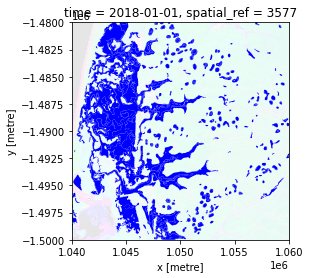

In [80]:
ax = plt.subplot(1, 1, 1)
rgb(ds, bands=['BS_PC_90', 'PV_PC_90', 'NPV_PC_90'], ax=ax, alpha=0.1)
this_tile.plot(ax=ax, facecolor='blue')
ax.set_xlim(1.04e6, 1.06e6)
ax.set_ylim(-1.50e6, -1.48e6)

Rasterise this tile of wetlands so we can quickly mask.

In [29]:
raster_wetland = rasterio.features.rasterize(shapes=this_tile.buffer(0),
                                             out_shape=ds.y.shape + ds.x.shape,
                                             all_touched=False,
                                             default_value=1,
                                             fill=0,
                                             transform=ds.geobox.transform)

In [54]:
features = {
    'BS_PC_90': ds.BS_PC_90,
    'PV_PC_90': ds.PV_PC_90,
    'NPV_PC_90': ds.NPV_PC_90,
}

for feature, da_feature in features.items():
    values = da_feature.isel(time=0).values
    nodata = values == da_feature.nodata
    wetland_mask = raster_wetland.astype(bool)
    wet = values[wetland_mask & ~nodata]
    nonwet = values[~wetland_mask & ~nodata]
    
    features[feature] = (wet, nonwet)

In [57]:
wet_hist, wet_x, wet_y = np.histogram2d(features['NPV_PC_90'][0], features['PV_PC_90'][0], bins=30)
nonwet_hist, nonwet_x, nonwet_y = np.histogram2d(features['NPV_PC_90'][1], features['PV_PC_90'][1], bins=30)

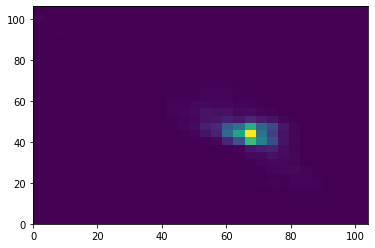

In [59]:
plt.pcolormesh(nonwet_y, nonwet_x, nonwet_hist)

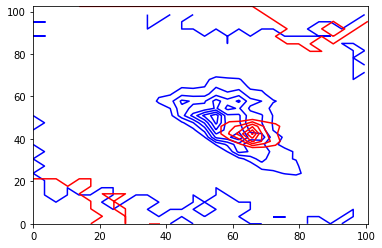

In [78]:
llc = matplotlib.ticker.SymmetricalLogLocator(linthresh=1, base=10)
plt.contour(wet_y[:-1], wet_x[:-1], wet_hist, colors='blue')  # locator = llc if you want log contours.
plt.contour(nonwet_y[:-1], nonwet_x[:-1], nonwet_hist, colors='red')